# Tweet Sentiment Using Natural Language Processing

## Buisiness Problem
An online publication group would like to use twitter data as a tool to help inform their writers as to which subjects are of interest to those who use that platform. The goal is to be able to use the twitter API to pull tweets on a given subject, describe the overall sentiment of the tweet, and determine which words are most commonly used within those categroies. The result should help writers narrow down their research enabling them to more efficiently produce content that will generate interest and focus on the most relevent subjects. This project is meant to be a proof of concept centered around the 2012 SXSW conference, specifically tweets about Google and Apple who both tend to have a huge presence at the event. Typically this consists releasing new products, hosting events, and inviting guest speakers.  

In [498]:
#importing relevent libraries

import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from nltk import FreqDist 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [499]:
data=pd.read_csv("Data/tweet_data.csv", encoding="latin-1") 
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


## Initial Data Exploration

In [500]:
#These column names, while very descriptive, need to be more user friendly
data = data.rename(columns = {'tweet_text':'text',
                              'emotion_in_tweet_is_directed_at':'product',
                              'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'})

In [501]:
data['product'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [502]:
#For our purposes we will just look at brands, as our focus is on brand presence at sxsw
prod_replace_dict = {                     
                     'iPhone':'Apple',
                     'iPad':'Apple',
                     'iPad or iPhone App':'Apple',
                     'Other Apple product or service':'Apple',
                     'Android':'Google',
                     'Android App':'Google',
                     'Other Google product or service':'Google'
}

sent_replace_dict = {
                     'No emotion toward brand or product':'No Emotion',
                     'Positive emotion':'Positive',
                     'Negative emotion':'Negative'
}

In [503]:
data['product'] = data['product'].replace(prod_replace_dict)
data['sentiment'] = data['sentiment'].replace(sent_replace_dict)
data.head()

,text,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Apple,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Apple,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,Apple,Positive
3,@sxsw I hope this year's festival isn't as cra...,Apple,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive


### Distributions

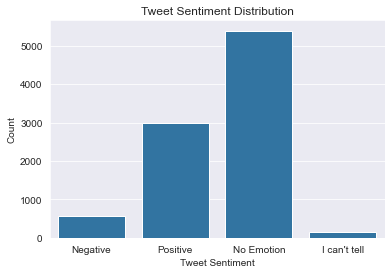

In [504]:
fig, ax = plt.subplots()

sns.countplot(x=data['sentiment'], data = data, color='tab:blue')

ax.set(
    xlabel='Tweet Sentiment', ylabel='Count', title='Tweet Sentiment Distribution'
);

The vest majority of tweets overall convey a neutral emotion. We will need to address class imbalance once we start modeling the data. 

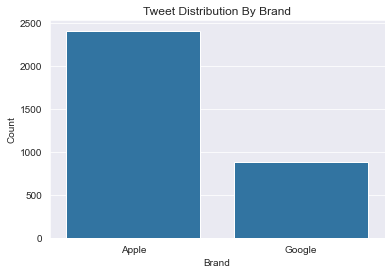

In [505]:
fig, ax = plt.subplots()

classes = ['Apple', 'Google']
sns.countplot(x=data['product'], data = data, color='tab:blue', order=classes)

ax.set(xticklabels=['Apple', 'Google'], 
       xlabel='Brand', ylabel='Count', title='Tweet Distribution By Brand');
#It looks like there are a large majority of tweets that arent directed at either of our brands

It also appears that Apple generated more interest than google at this particular event. 

In [506]:
data.isna().sum()
#Over half of the tweets in this dataset aren't directed at a given product or brand.

text            1
product      5802
sentiment       0
dtype: int64

In [507]:
data[data['product'].isnull()]
#from a quick glance we can see that some of these tweets definitely pertain to our business problem.

,text,product,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No Emotion
6,NaN,NaN,No Emotion
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No Emotion
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No Emotion
33,Anyone at #sxsw want to sell their old iPad?,NaN,No Emotion
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No Emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No Emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No Emotion
9091,Some Verizon iPhone customers complained their...,NaN,No Emotion


In [508]:
data['text'] = data['text'].str.lower()
data.head()

#we can standardize case here without causing data leakage, thereby making our next step easier

,text,product,sentiment
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Apple,Negative
1,@jessedee know about @fludapp ? awesome ipad/i...,Apple,Positive
2,@swonderlin can not wait for #ipad 2 also. the...,Apple,Positive
3,@sxsw i hope this year's festival isn't as cra...,Apple,Negative
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive


In [509]:
#We can drop the single NaN value in the text column, which is necessary for this next step to work
data.dropna(subset=['text'], inplace = True)
data.reset_index(drop=True, inplace=True)

In [510]:
#preliminary count prior to reclassifying tweets
data['product'].value_counts()

Apple     2409
Google     882
Name: product, dtype: int64

In [511]:
#this block of code will classify any tweet mentioning a specific product as such
google_words = ['android', '#google', 'google']
apple_words = ['iphone', 'ipad', 'mac', 'apple', '#apple']

for index in range(len(data)):
    if (any(word in data['text'][index] for word in google_words) == True):
        data['product'][index] = 'Google'
    else:
        pass
for index in range(len(data)):
    if (any(word in data['text'][index] for word in apple_words) == True):
        data['product'][index] = 'Apple'
    else:
        pass

In [512]:
#this leaves us with a much higher number of tweets to work with
data['product'].value_counts()

Apple     5569
Google    2767
Name: product, dtype: int64

In [513]:
null=data.loc[data['product'].isnull() == True]
null.head()

,text,product,sentiment
50,ûï@mention {link} &lt;-- help me forward this...,NaN,No Emotion
51,÷¼ what? ÷_ {link} ã_ #edchat #musedchat #s...,NaN,No Emotion
52,.@mention @mention on the location-based 'fast...,NaN,No Emotion
65,at #sxsw? @mention / @mention wanna buy you a ...,NaN,No Emotion
70,chilcott: @mention #sxsw stand talking with bl...,NaN,No Emotion


In [514]:
print(len(null))
#These tweets likely don't pertain to our products and aren't useful for our model

756


In [515]:
data = data.dropna(axis=0)

In [516]:
data = data[data['sentiment'] != "I can't tell"]
data['sentiment'].value_counts()
#With so few "I can't tell" values, it doesnt make sense to classify them
#With such a large class imbalance, it makes sense to stratify our train and test sets

No Emotion    4652
Positive      2965
Negative       569
Name: sentiment, dtype: int64

## Basic Data Vizualization

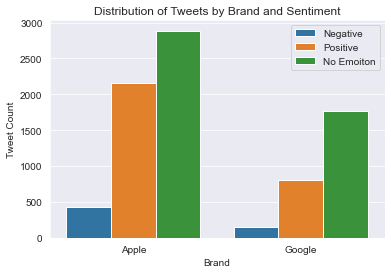

In [517]:
fig, ax = plt.subplots()
sns.countplot(x='product', data=data, hue='sentiment')

ax.set(title='Distribution of Tweets by Brand and Sentiment', 
       xticklabels=['Apple', 'Google'], 
       xlabel='Brand', ylabel='Tweet Count')
ax.legend(['Negative', 'Positive', 'No Emoiton'])

plt.show()


As we discovered earlier, Apple did generate more tweets that Google, however distributions of positive to negative tweets seem consistent between the two brands. No emotion remains the most common sentiment. 

## Data Cleaning
We will be able to develop more useful visualizations after we clean up our tweets a little bit. 

In [518]:
#train test split to avoid data leakage 

X = data.drop('sentiment', axis=1)
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, stratify=y)

In [519]:
X_train

,text,product
8322,oooh. want. rt @mention #recap from recycled s...,Apple
6197,rt @mention josh clark: i hate the ipad's bac...,Apple
5383,rt @mention almost every &quot;how do you ____...,Google
1833,it's not a rumor: #apple is opening up a pop-u...,Apple
5149,rt @mention @mention shows #apple 's position ...,Apple
...,...,...
9073,at &quot;your mom has an ipad: designing for b...,Apple
5941,rt @mention got the #vmware talent community i...,Apple
2783,getting ready for my ipad 2 vs android panel a...,Apple
8172,hmmm... rt @mention google to launch major new...,Google


In [520]:
train_text = X_train['text']
test_text = X_test['text']

In [521]:
#This block of code will retun all groupings beginning with @ and containing all allowable twitter username characters

for line in train_text:    
    p = re.findall(r'@([A-Za-z0-9_]+)', line)
    if p != 0:
        print(p)

['mention']
['mention']
['mention']
['mention']
['mention', 'mention']
[]
[]
['mention']
[]
['mention', 'mention']
['mention', 'mention', 'mention']
['mention']
['mention', 'mention']
['mention']
['mention']
[]
['mention']
[]
['mention']
[]
['mention']
['mention']
[]
[]
['mention']
['mention', 'mention']
[]
[]
[]
['mention']
[]
[]
['mention']
[]
[]
['mention']
['mention']
[]
[]
[]
['mention']
[]
[]
['mention', 'mention']
['mention', 'mention']
['mention', 'mention']
[]
[]
[]
[]
[]
['mention']
[]
[]
['mention']
[]
[]
['mention', 'mention', 'mention']
['mention', 'mention']
['mention']
['mention']
['mention']
[]
['mention']
['mention']
[]
[]
['mention']
['mention']
['mention']
[]
['mention']
['mention']
['mention', 'mention']
['mention']
['mention', 'mention', 'mention', 'mention']
['mention']
[]
[]
[]
[]
['mention']
[]
[]
['mention']
['mention']
['mention']
[]
['mention', 'mention']
['mention', 'mention']
[]
['mention']
['mention']
['mention']
[]
['mention']
['mention']
['mention', 'men

In [522]:
#removing twitter handles for both data sets
for line in train_text:    
    new_line = re.sub(r'@([A-Za-z0-9_]+)','', line)
    train_text.replace(line, new_line, inplace=True)      
    
for line in test_text:
    new_line = re.sub(r'@([A-Za-z0-9_]+)','', line)
    train_text.replace(line, new_line, inplace=True)

In [523]:
train_text.head()

8322    oooh. want. rt  #recap from recycled skateboar...
6197    rt  josh clark:  i hate the ipad's back button...
5383    rt  almost every &quot;how do you _______?&quo...
1833    it's not a rumor: #apple is opening up a pop-u...
5149    rt   shows #apple 's position in the tablet wa...
Name: text, dtype: object

In [524]:
#removing punctuation

for line in train_text:
    new_line = line.translate(str.maketrans('', '', string.punctuation))
    train_text.replace(line, new_line, inplace=True)

for line in test_text:
    new_line = line.translate(str.maketrans('', '', string.punctuation))

In [525]:
train_text

8322    oooh want rt  recap from recycled skateboards ...
6197    rt  josh clark  i hate the ipads back button w...
5383    rt  almost every quothow do you quot is answer...
1833    its not a rumor apple is opening up a popup st...
5149    rt   shows apple s position in the tablet wars...
                              ...                        
9073    at quotyour mom has an ipad designing for boom...
5941    rt  got the vmware talent community ipad app r...
2783    getting ready for my ipad 2 vs android panel a...
8172    hmmm rt  google to launch major new social net...
4051    sxsw panel google envisions search without sea...
Name: text, Length: 6139, dtype: object

In [526]:
#splitting text prior to tokenizing 

train_text.str.split()
test_text.str.split()

7808    [will, i, survive, #sxsw, will, only, 1.6, gig...
4069    [@mention, launching, gowalla, 3, for, droid, ...
2331    [#techcrunch, #google, launchrock, and, vencor...
3807    [zomg, its, ipad, 2, :p, rt, @mention, look, e...
459     [before, it, even, begins,, #apple, #winning, ...
                              ...                        
4431    [i, think, an, ipad, is, eminent., typing, tho...
6258    [rt, @mention, listening, to, marissa, meyer,,...
526     [good, talk, from, akqas, @mention, on, ipad, ...
8570    [&quot;tattoo, for, an, ipad&quot;, chalked, o...
4230    [#sxsw, #help, request:, where's, the, downtow...
Name: text, Length: 2047, dtype: object

In [527]:
#using standard regex pattern to tokenize tweets 
from nltk.tokenize import RegexpTokenizer
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

In [528]:
# Create new column with tokenized data
X_train["text_tokenized"] = train_text.apply(tokenizer.tokenize)
# Display full text
X_train['text_tokenized']

8322    [oooh, want, rt, recap, from, recycled, skateb...
6197    [rt, josh, clark, hate, the, ipads, back, butt...
5383    [rt, almost, every, quothow, do, you, quot, is...
1833    [its, not, rumor, apple, is, opening, up, popu...
5149    [rt, shows, apple, position, in, the, tablet, ...
                              ...                        
9073    [at, quotyour, mom, has, an, ipad, designing, ...
5941    [rt, got, the, vmware, talent, community, ipad...
2783    [getting, ready, for, my, ipad, vs, android, p...
8172    [hmmm, rt, google, to, launch, major, new, soc...
4051    [sxsw, panel, google, envisions, search, witho...
Name: text_tokenized, Length: 6139, dtype: object

In [529]:
def visualize_top_20(freq_dist, title):

    # Extract data for plotting
    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    # Set up plot and plot data
    fig, ax = plt.subplots()
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    

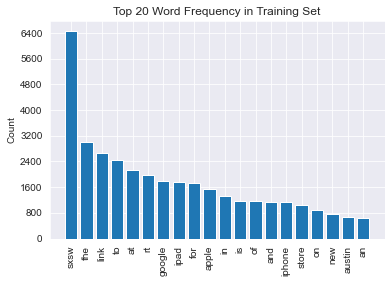

In [530]:
visualize_top_20(X_train_freq_dist, "Top 20 Word Frequency in Training Set")

We can see here that most of our most commonly used words either are stopwords 

In [531]:
stopwords_list = stopwords.words('english')

def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

In [532]:
X_train["text_without_stopwords"] = X_train["text_tokenized"].apply(remove_stopwords)

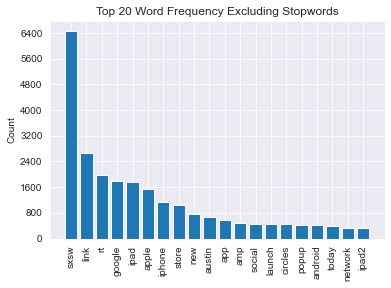

In [533]:

# Create a frequency distribution for X_train
train_freq_dist = FreqDist(X_train["text_without_stopwords"].explode())

# Plot the top 20 tokens
visualize_top_20(train_freq_dist, "Top 20 Word Frequency Excluding Stopwords")

This is better, but many of these words are twitter characters (rt, link, amp, quot) or are specific to the conference (austin, sxsw) we should remove all of these.

In [534]:
#these words are very common but don't tell us much about the tweet itself.
sxsw_list = ['sxsw', 'rt', 'link', 'quot', 'austin', 'amp']

def remove_sxsw(token_list):
    sxsw_removed = [token for token in token_list if token not in sxsw_list]
    return sxsw_removed

X_train["text_without_stopwords"] = X_train["text_without_stopwords"].apply(remove_sxsw)
X_train['text_without_stopwords'].head()

8322    [oooh, want, recap, recycled, skateboards, iph...
6197    [josh, clark, hate, ipads, back, button, heat,...
5383    [almost, every, quothow, answered, google, doc...
1833    [rumor, apple, opening, popup, store, downtown...
5149    [shows, apple, position, tablet, wars, tapworthy]
Name: text_without_stopwords, dtype: object

In [535]:
#the next step is to lemmatize text to combine different tenses of some words   
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

X_train['lemmatized_text']=X_train['text_without_stopwords'].apply(lemmatize_text)

## Secondary Data Visualization

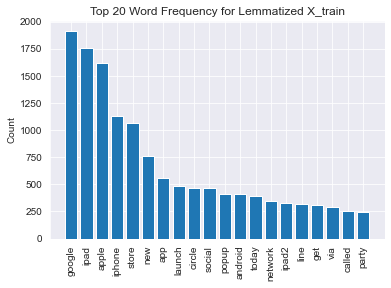

In [536]:
# Create a frequency distribution for X_train
train_freq_dist = FreqDist(X_train["lemmatized_text"].explode())

# Plot the top 20 tokens
visualize_top_20(train_freq_dist, "Top 20 Word Frequency for Lemmatized X_train")

This is interesting, despite generating more 'buzz' than Google, Apple is the third most common word, as it's products are somewhat synonymous with the brand itself.

In [537]:
#We will use a copy of the training data to generate some word clouds
processed_data = X_train.copy()
processed_data['label'] = [y_train[idx] for idx in processed_data.index]

apple_df = processed_data[processed_data['product'] == 'Apple']
apple_pos_df = apple_df[apple['label'] == 'Positive']
apple_neg_df = apple_df[apple['label'] == 'Negative']

google_df = processed_data[processed_data['product'] == 'Google']
google_pos_df = google_df[google_df['label'] == 'Positive']
google_neg_df = google_df[google_df['label'] == 'Negative']

In [538]:
apple['final_text'] = apple['lemmatized_text'].apply(lambda x: ' '.join(x))
google['final_text'] = google['lemmatized_text'].apply(lambda x: ' '.join(x))

In [539]:
apple_positive = apple['final_text'].loc[apple['label']=='Positive'].tolist()
apple_positive = ' '.join(apple_positive)

apple_negative = apple['final_text'].loc[apple['label']=='Negative'].tolist()
apple_negative = ' '.join(apple_negative)

In [540]:
google_positive = google['final_text'].loc[google['label']=='Positive'].tolist()
google_positive = ' '.join(google_positive)

google_negative = google['final_text'].loc[google['label']=='Negative'].tolist()
google_negative = ' '.join(google_negative)

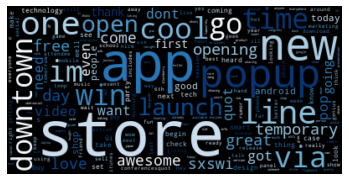

In [541]:
#generating word cloud for positive apple tweets, excluding obvious words
wordcloud = WordCloud(collocations=False, colormap='Blues').generate(apple_positive.replace(
    'apple','').replace(
    'ipad','').replace(
    'iphone',''))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

'Store' is an interesting word in this cloud, lets take a look at a few tweets than mention the word.

In [542]:
apple_pos_df[apple_pos_df['text'].str.contains('store')].head()

,text,product,text_tokenized,text_without_stopwords,lemmatized_text,label
1833,its not a rumor apple is opening up a popup st...,Apple,"[its, not, rumor, apple, is, opening, up, popu...","[rumor, apple, opening, popup, store, downtown...","[rumor, apple, opening, popup, store, downtown...",Positive
5303,rt sxsw is sxsw getting its own apple store t...,Apple,"[rt, sxsw, is, sxsw, getting, its, own, apple,...","[getting, apple, store, geeks, cried, yes, ipa...","[getting, apple, store, geek, cried, yes, ipad...",Positive
5448,rt apple opening popup store for ipad launch ...,Apple,"[rt, apple, opening, popup, store, for, ipad, ...","[apple, opening, popup, store, ipad, launch, d...","[apple, opening, popup, store, ipad, launch, d...",Positive
6417,rt ooooo apple rumored to be opening a tempor...,Apple,"[rt, ooooo, apple, rumored, to, be, opening, t...","[ooooo, apple, rumored, opening, temporary, st...","[ooooo, apple, rumored, opening, temporary, st...",Positive
7066,apples popup store plans for sxsw in austin link,Apple,"[apples, popup, store, plans, for, sxsw, in, a...","[apples, popup, store, plans]","[apple, popup, store, plan]",Positive


In [543]:
print(apple_pos_df.loc[1833, 'text'])

its not a rumor apple is opening up a popup store in downtown austin for sxsw amp ipad 2 launch via  link


It appears that Apple opened a popup store for the highly anticipated launch of the iPad 2, which occured during the event. Now lets take a look at the negatives.

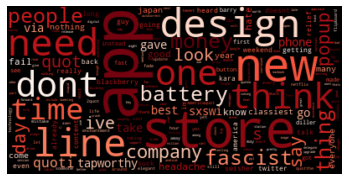

In [544]:
#generating negative wordcloud for apple products
wordcloud = WordCloud(
    max_font_size=75,
    collocations=False, 
    colormap="Reds")
wordcloud.generate(apple_negative.replace(
    'apple','').replace(
    'ipad','').replace(
    'iphone',''))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [545]:
apple_neg_df[apple_neg_df['text'].str.contains('design')].head()

,text,product,text_tokenized,text_without_stopwords,lemmatized_text,label
2779,getting ready for quotipad design headachesquo...,Apple,"[getting, ready, for, quotipad, design, headac...","[getting, ready, quotipad, design, headachesquot]","[getting, ready, quotipad, design, headachesquot]",Negative
7817,guess everyone wanted to design ipad apps for ...,Apple,"[guess, everyone, wanted, to, design, ipad, ap...","[guess, everyone, wanted, design, ipad, apps, ...","[guess, everyone, wanted, design, ipad, apps, ...",Negative
2318,the ipad calendar the frankeninterface design...,Apple,"[the, ipad, calendar, the, frankeninterface, d...","[ipad, calendar, frankeninterface, designed, o...","[ipad, calendar, frankeninterface, designed, o...",Negative
6154,rt ipad design malady ipad elbow i hate the ...,Apple,"[rt, ipad, design, malady, ipad, elbow, hate, ...","[ipad, design, malady, ipad, elbow, hate, ipad...","[ipad, design, malady, ipad, elbow, hate, ipad...",Negative
5131,rt ipad app getting panned for design trumpi...,Apple,"[rt, ipad, app, getting, panned, for, design, ...","[ipad, app, getting, panned, design, trumping,...","[ipad, app, getting, panned, design, trumping,...",Negative


In [546]:
print(apple_neg_df.loc[6154, 'text'])

rt  ipad design malady ipad elbow  i hate the ipads back button with the heat of a million suns tapworthy sxsw


Given that this is a retweet, at least two people hate the iPad 2 back button. The design of this product in general seems to have attracted quite a bit of negative attention

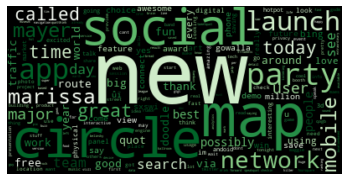

In [547]:
wordcloud = WordCloud(collocations=False, colormap='Greens').generate(google_positive.replace(
    'google', '').replace('android', ''))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [548]:
google_pos_df[google_pos_df['text'].str.contains('marissa')].head()

,text,product,text_tokenized,text_without_stopwords,lemmatized_text,label
5937,rt googles route around traffic function save...,Google,"[rt, googles, route, around, traffic, function...","[googles, route, around, traffic, function, sa...","[google, route, around, traffic, function, sav...",Positive
4273,googles marissa mayer on the locationbased fas...,Google,"[googles, marissa, mayer, on, the, locationbas...","[googles, marissa, mayer, locationbased, fast,...","[google, marissa, mayer, locationbased, fast, ...",Positive
4,great stuff on fri sxsw marissa mayer google ...,Google,"[great, stuff, on, fri, sxsw, marissa, mayer, ...","[great, stuff, fri, marissa, mayer, google, ti...","[great, stuff, fri, marissa, mayer, google, ti...",Positive
6300,rt marissa mayer google will connect the digi...,Google,"[rt, marissa, mayer, google, will, connect, th...","[marissa, mayer, google, connect, digital, phy...","[marissa, mayer, google, connect, digital, phy...",Positive
845,since im listening to googles marissa mayer bu...,Google,"[since, im, listening, to, googles, marissa, m...","[since, im, listening, googles, marissa, mayer...","[since, im, listening, google, marissa, mayer,...",Positive


In [549]:
print(google_pos_df.loc[5937, 'text'])

rt  googles route around traffic function saves users 2 years every day good for future ûó marissa mayer at sxsw


It looks like Google's Marissa Mayer had a very well received presentation at the conference. Some quick research reveals that she was hired by the company in 1999 as their 20th employee.

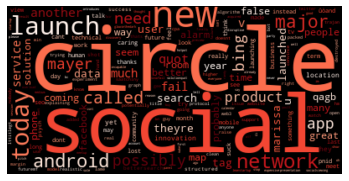

In [550]:
wordcloud = WordCloud(collocations=False, colormap='Reds').generate(google_negative.replace('google',''))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [551]:
#circle was featured heavily in both positive and negative tweets
google_neg_df[google_neg_df['text'].str.contains('circle')].head()

,text,product,text_tokenized,text_without_stopwords,lemmatized_text,label
7700,false alarm google circles not coming nowûòan...,Google,"[false, alarm, google, circles, not, coming, n...","[false, alarm, google, circles, coming, ûòand,...","[false, alarm, google, circle, coming, ûòand, ...",Negative
3330,google circles will be lame sxsw lt3,Google,"[google, circles, will, be, lame, sxsw, lt3]","[google, circles, lame, lt3]","[google, circle, lame, lt3]",Negative
7574,google circles is not a real thing and will no...,Google,"[google, circles, is, not, real, thing, and, w...","[google, circles, real, thing, launched, today]","[google, circle, real, thing, launched, today]",Negative
5088,rt false alarm google circles not coming n...,Google,"[rt, false, alarm, google, circles, not, comin...","[false, alarm, google, circles, coming, ûòand,...","[false, alarm, google, circle, coming, ûòand, ...",Negative
6021,rt hm do we need another 1 rt google to laun...,Google,"[rt, hm, do, we, need, another, rt, google, to...","[hm, need, another, google, launch, major, new...","[hm, need, another, google, launch, major, new...",Negative


In [552]:
print(google_neg_df.loc[7574, 'text'])

google circles is not a real thing and will not be launched today at sxsw link


Apparently, a social networkd called Circles was supposed to be launched at the conference, but the launch never occured. That explains the split in sentiment. 

## Modeling Data
Now that we have shown the insight that can quickly be pulled from the data, we need to build a classification model that can detect the sentiment of tweets with a reasonable level of accuracy. A Multinomial Naive Bayes model is one of the leading algorithms for language processing. We will apply it to our unprocessed data as a baseline model and then see if processing and tuning yields better results.

In [553]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with a low level of max_features (10)
tfidf = TfidfVectorizer(max_features=10)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train["text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out())

,apple,at,for,google,ipad,link,rt,sxsw,the,to
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.603678,0.726988,0.327203,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.486157,0.218809,0.846034,0.000000
2,0.000000,0.000000,0.000000,0.685547,0.000000,0.000000,0.663885,0.298801,0.000000,0.000000
3,0.531608,0.000000,0.515449,0.000000,0.493919,0.400719,0.000000,0.217196,0.000000,0.000000
4,0.560506,0.000000,0.000000,0.000000,0.000000,0.422501,0.508803,0.229002,0.442722,0.000000
...,...,...,...,...,...,...,...,...,...,...
6134,0.000000,0.479803,0.533940,0.000000,0.511638,0.415095,0.000000,0.224988,0.000000,0.000000
6135,0.000000,0.000000,0.000000,0.000000,0.532330,0.431882,0.520100,0.234086,0.452552,0.000000
6136,0.000000,0.778772,0.433321,0.000000,0.415222,0.000000,0.000000,0.182589,0.000000,0.000000
6137,0.000000,0.000000,0.000000,0.527912,0.000000,0.424517,0.511231,0.230095,0.000000,0.476229


In [554]:
baseline_model = MultinomialNB()

baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

array([0.56840391, 0.56840391, 0.56840391, 0.56840391, 0.56805216])

In [557]:
X_train['final_text'] = X_train['lemmatized_text'].apply(lambda x: ' '.join(x))

In [561]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate a vectorizer with a low level of max_features (10)
tfidf = TfidfVectorizer()

# Fit the vectorizer on X_train["text"] and transform it
processed_vectorized = tfidf.fit_transform(X_train["final_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(processed_vectorized, columns=tfidf.get_feature_names_out())

,02,03,0310apple,031111,031211,10,100,1000,10000,100000,...,ûïthe,ûïview,ûïwin,ûò,ûòand,ûó,ûólewis,ûólots,ûómy,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [562]:
untuned_processed = MultinomialNB()

processed_cv = cross_val_score(untuned_processed, processed_vectorized, y_train)
processed_cv

array([0.62214984, 0.64169381, 0.63843648, 0.6514658 , 0.6193969 ])